In [24]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "vscode"
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, explode, col, regexp_replace, transform, isnan

spark = SparkSession.builder.appName("LightcastCleanedData").getOrCreate()

# 重新加载处理后的数据
df_cleaned = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").csv("data/lightcast_cleaned.csv")

# 查看数据结构和样本
df_cleaned.show()

+--------------------+-----------------+----------------------+----------+----------+----------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+---------+--------------------+--------------------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+------------------+------+--------------------+-----+--------------------+-----+-------------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+-------

In [34]:
df_cleaned.select("ONET", "ONET_NAME", "ONET_2019", "ONET_2019_NAME").show(10, False)

+----------+------------------------------+----------+------------------------------+
|ONET      |ONET_NAME                     |ONET_2019 |ONET_2019_NAME                |
+----------+------------------------------+----------+------------------------------+
|15-2051.01|Business Intelligence Analysts|15-2051.01|Business Intelligence Analysts|
|15-2051.01|Business Intelligence Analysts|15-2051.01|Business Intelligence Analysts|
|15-2051.01|Business Intelligence Analysts|15-2051.01|Business Intelligence Analysts|
|15-2051.01|Business Intelligence Analysts|15-2051.01|Business Intelligence Analysts|
|15-2051.01|Business Intelligence Analysts|15-2051.01|Business Intelligence Analysts|
|15-2051.01|Business Intelligence Analysts|15-2051.01|Business Intelligence Analysts|
|15-2051.01|Business Intelligence Analysts|15-2051.01|Business Intelligence Analysts|
|15-2051.01|Business Intelligence Analysts|15-2051.01|Business Intelligence Analysts|
|15-2051.01|Business Intelligence Analysts|15-2051.01|

In [8]:
from pyspark.sql.functions import col, when
# Create a new column EDU_MATCH, mark it as a match or not
df_compare = df_cleaned.withColumn(
    "EDU_MATCH",
    when(col("ONET") == col("ONET_2019"), "Match").otherwise("Mismatch")
)

df_compare.select("ONET", "ONET_2019", "EDU_MATCH").show(truncate=False)

# 统计不匹配的行数
unmatched_count = df_cleaned.filter(col("MIN_EDULEVELS") != col("EDUCATION_LEVELS")).count()
print(f"Not Match: {unmatched_count}")

+----------+----------+---------+
|ONET      |ONET_2019 |EDU_MATCH|
+----------+----------+---------+
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
|15-2051.01|15-2051.01|Match    |
+----------+----------+---------+
only showing top 20 rows



Not Match: 0


In [9]:
from pyspark.sql.functions import col, when
# Create a new column EDU_MATCH, mark it as a match or not
df_compare = df_cleaned.withColumn(
    "EDU_MATCH",
    when(col("ONET_NAME") == col("ONET_2019_NAME"), "Match").otherwise("Mismatch")
)

df_compare.select("ONET_NAME", "ONET_2019_NAME", "EDU_MATCH").show(truncate=False)

# 统计不匹配的行数
unmatched_count = df_cleaned.filter(col("MIN_EDULEVELS") != col("EDUCATION_LEVELS")).count()
print(f"Not Match: {unmatched_count}")

+------------------------------+------------------------------+---------+
|ONET_NAME                     |ONET_2019_NAME                |EDU_MATCH|
+------------------------------+------------------------------+---------+
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Business Intelligence Analysts|Match    |
|Business Intelligence Analysts|Busine

Not Match: 0


k = 2, SSE = 54624.72


k = 3, SSE = 37793.47


k = 4, SSE = 29496.78


k = 5, SSE = 25203.56


k = 6, SSE = 20780.78


k = 7, SSE = 17682.33


k = 8, SSE = 15486.21


k = 9, SSE = 13970.85


k = 10, SSE = 12718.51


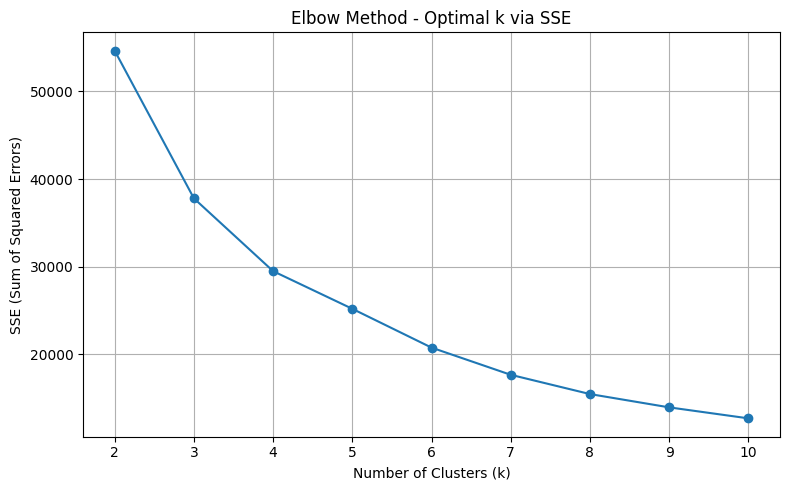

In [35]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt

# === 选择用于聚类的字段 ===
numeric_cols = ["DURATION", "EDUCATION_LEVELS", "SALARY"]
df_kmeans = df_cleaned.select(numeric_cols + ["TITLE_RAW"]).dropna()

# === 类型转换 ===
for col_name in numeric_cols:
    df_kmeans = df_kmeans.withColumn(col_name, col(col_name).cast(DoubleType()))

# === 特征组合 + 标准化步骤 ===
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="raw_features")
scaler = StandardScaler(inputCol="raw_features", outputCol="features", withStd=True, withMean=True)

# === 遍历不同 k 值，收集 silhouette 得分 ===
cost = []
for k in range(2, 11):
    kmeans = KMeans(k=k, seed=688, featuresCol="features")
    pipeline = Pipeline(stages=[assembler, scaler, kmeans])
    model = pipeline.fit(df_kmeans)
    
    # 获取 KMeans 聚类模型阶段（Pipeline 的最后一个 stage）
    kmeans_model = model.stages[-1]
    sse = kmeans_model.summary.trainingCost
    cost.append((k, sse))
    print(f"k = {k}, SSE = {sse:.2f}")

# 绘制 Elbow 图（原始版本）
k_vals, sse_vals = zip(*cost)
plt.figure(figsize=(8, 5))
plt.plot(k_vals, sse_vals, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("SSE (Sum of Squared Errors)")
plt.title("Elbow Method - Optimal k via SSE")
plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:
# KMeans 模型
kmeans = KMeans(k=4, seed=688, featuresCol="features", predictionCol="cluster")

# 管道构建
pipeline = Pipeline(stages=[assembler, scaler, kmeans])
model = pipeline.fit(df_kmeans)
clustered = model.transform(df_kmeans)

# 收集结果评估
rows = clustered.select("TITLE_RAW", "cluster").collect()
df_clustered = pd.DataFrame([row.asDict() for row in rows])

# sklearn 评估
le = LabelEncoder()
true_labels = le.fit_transform(df_clustered["TITLE_RAW"])
pred_labels = df_clustered["cluster"]

nmi = normalized_mutual_info_score(true_labels, pred_labels)
ari = adjusted_rand_score(true_labels, pred_labels)

print(f"NMI: {nmi:.4f}")
print(f"ARI: {ari:.4f}")

print("TITLE_RAW:")
print(df_clustered.groupby("cluster")["TITLE_RAW"].agg(lambda x: x.value_counts().index[0]))

print("cluster:")
print(df_clustered["cluster"].value_counts().sort_index())

NMI: 0.2122
ARI: 0.0051
TITLE_RAW:
cluster
0            Data Analyst
1            Data Analyst
2            Data Analyst
3    Enterprise Architect
Name: TITLE_RAW, dtype: object
cluster:
cluster
0    9322
1    7574
2    6099
3    4328
Name: count, dtype: int64


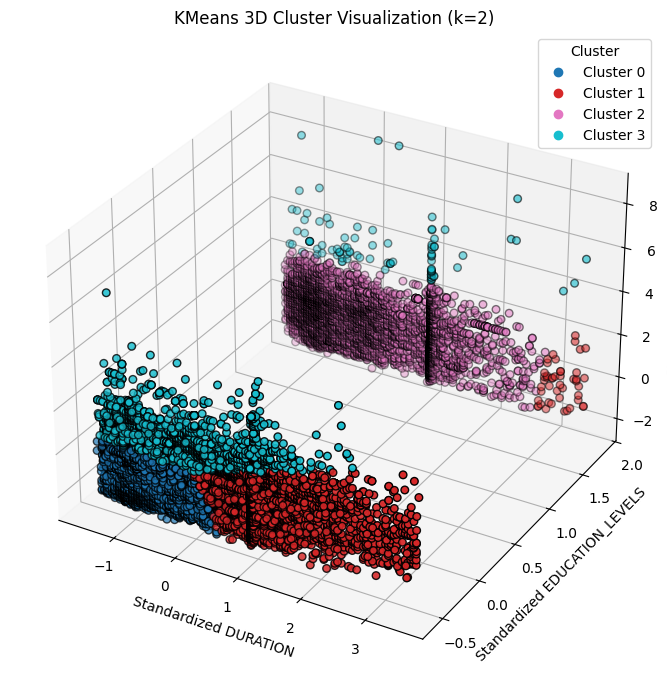

In [47]:
from pyspark.ml.functions import vector_to_array
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D 绘图支持

# Step 1: 将 Spark 向量拆成 3 个列
df_plot = clustered.select(vector_to_array("features").alias("features_array"), "cluster")
df_plot_pd = df_plot.toPandas()

# Step 2: 转为 Pandas 的 DataFrame（3列特征 + cluster）
features_df = pd.DataFrame(df_plot_pd["features_array"].tolist(), columns=["DURATION_std", "EDU_LEVEL_std", "SALARY_std"])
features_df["cluster"] = df_plot_pd["cluster"]

# Step 3: 画 3D 散点图
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    features_df["DURATION_std"],
    features_df["EDU_LEVEL_std"],
    features_df["SALARY_std"],
    c=features_df["cluster"],
    cmap="tab10",
    s=30,
    edgecolors='k'
)

ax.set_xlabel("Standardized DURATION")
ax.set_ylabel("Standardized EDUCATION_LEVELS")
ax.set_zlabel("Standardized SALARY")
ax.set_title(f"KMeans 3D Cluster Visualization (k={best_k})")

# 添加图例（根据聚类簇编号）
legend_labels = [f"Cluster {int(c)}" for c in sorted(features_df["cluster"].unique())]
ax.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Cluster")

plt.tight_layout()
plt.show()

In [3]:
# ===== 多元线性回归（标准化版本）=====
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import DoubleType

# 选择字段
lr_df = df_cleaned.select(
    "DURATION", "EDUCATION_LEVELS", "SALARY", "SALARY_FROM", "SALARY_TO"
).dropna()

# 类型转换
num_cols = ["DURATION", "EDUCATION_LEVELS", "SALARY", "SALARY_FROM", "SALARY_TO"]
for col_name in num_cols:
    lr_df = lr_df.withColumn(col_name, col(col_name).cast(DoubleType()))

# 拼接特征向量
assembler = VectorAssembler(
    inputCols=["DURATION", "EDUCATION_LEVELS", "SALARY_FROM", "SALARY_TO"],
    outputCol="assembled_features"
)

# 标准化
scaler = StandardScaler(inputCol="assembled_features", outputCol="features")

# 模型
lr = LinearRegression(featuresCol="features", labelCol="SALARY")

# 划分训练测试集
train_data, test_data = lr_df.randomSplit([0.8, 0.2], seed=42)
train_data = train_data.na.drop(subset=num_cols)
test_data = test_data.na.drop(subset=num_cols)

pipeline = Pipeline(stages=[assembler, scaler, lr])
model = pipeline.fit(train_data)
predictions = model.transform(test_data)

# 评估
evaluator_r2 = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="rmse")

r2 = evaluator_r2.evaluate(predictions)
rmse = evaluator_rmse.evaluate(predictions)

print("\n✅ 多元线性回归结果:")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")


25/04/19 20:42:57 WARN Instrumentation: [c0826b6d] regParam is zero, which might cause numerical instability and overfitting.



✅ 多元线性回归结果:
R²: 0.9991
RMSE: 1340.99
